[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/amgp-upm/pdsya/blob/main/image_retrieval_mnist_autoencoder.ipynb)

## Recuperación de imágenes basada en el contenido mediante autocodificadores

**La recuperación de imágenes basada en el contenido** (CBIR) es el mecanismo de recuperación de imágenes relevantes para una consulta dada de una gran colección de imágenes conocida como base de datos de imágenes, basada en su contenido semántico o visual en lugar de en atributos derivados o descriptores de palabras clave definidos prescriptivamente para ellos.

Como se muestra en la imagen, hay algunos pasos básicos que intervienen en la consulta y la recuperación:

- Extracción de características: Por supuesto, esta parte implica la extracción de las características de la imagen, como la textura, el color, etc. También podría considerarse un paso de preprocesamiento para, por ejemplo, cambiar el tamaño o mejorar la calidad de las imágenes.
- Medida de similitud: La medida de similitud se utiliza para estimar la imagen de consulta con las imágenes de la base de datos por similitud. La disimilitud entre el vector de características de la imagen de consulta y las imágenes de la base de datos se calcula utilizando diferentes métricas de distancia. Cuanto mayor sea la disimilitud, menos similares serán las dos imágenes. Algunas de las distancias más utilizadas son: Distancia euclidiana, distancia de bloque, distancia de Minkowski y distancia de Mahalanobis.
- Recuperar los resultados: Las N imágenes más similares se muestran al usuario.

![CBIR](https://raw.githubusercontent.com/amgp-upm/pdsya/730fd6c17d927c0ee7953bfdf6b724bb923d8618/images/cbir_01.jpg)

Este cuaderno se basa en el trabajo publicado por Rupapara et al. [<sup>1</sup>](#fn1). Aquí se utiliza una red neuronal especial llamada autoencoder para extraer las características de la imagen.

#### Loading libraries

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Flatten, Reshape
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt

#### Loading dataset

In [2]:
input_shape = (28, 28, 1)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Images come as vectors, so it is necessary to reshape them.
x_train = np.reshape(x_train, (len(x_train), input_shape[0], 
                               input_shape[1], input_shape[2]))
x_test = np.reshape(x_test, (len(x_test), input_shape[0], 
                             input_shape[1], input_shape[2]))

11490434/11490434 [==============================] - 0s 0us/step


### Fase de extracción de características: autoencoder

Un autoencoder es una red neuronal no supervisada, lo que significa que no requiere ningún dato etiquetado. 

Funcionan comprimiendo la entrada en una representación de espacio latente y reconstruyendo la salida a partir de esta representación:

- Codificador: es la parte de la red que comprime la entrada en una representación del espacio latente (es decir, la representación de los datos comprimidos). Puede representarse mediante una función de codificación \\( h=f(x) \\).
- Decodificador: Esta parte tiene como objetivo reconstruir la entrada a partir de la representación del espacio latente. Puede ser representada por una función de decodificación \\( r=g(h) \\).

![CBIR Autoencoder](https://raw.githubusercontent.com/amgp-upm/pdsya/main/images/cbir_02.jpg)

In [3]:
# Definition of the autoencoder network

def autoencoder_model(input_shape=(28, 28, 1)):
    """ Autoencoder model """
    input_img = Input(shape=input_shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    encoded = Flatten(name='encoder')(x)

    x = Reshape((4, 4, 8))(encoded)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

autoencoder = autoencoder_model()
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584   

#### Autoencoder para la eliminación de ruido

En lugar de entrenar al autoencoder para que aprenda una imagen original y la reconstruya, vamos a entrenarlo para que pueda quitar el ruido a una imagen. Para ello, modificamos la entrada añadiendo un poco de ruido mantendrá la imagen original como objetivo.

1/1 [==============================] - 0s 17ms/step


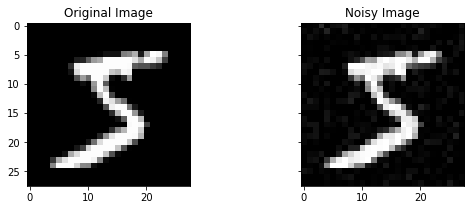

1/1 [==============================] - 0s 17ms/step


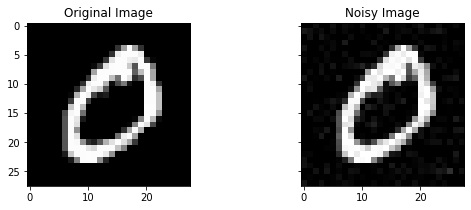

1/1 [==============================] - 0s 17ms/step


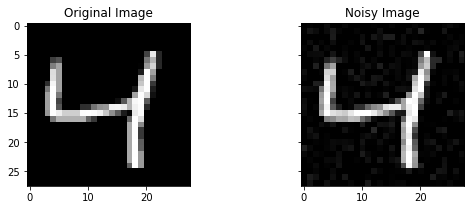

In [7]:
# Adding noise to images

noise_factor = 0.05

x_train_noisy = x_train + noise_factor * np.random.normal(
    loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(
    loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

for idx in range(3):
    y = autoencoder.predict(np.expand_dims(x_train_noisy[idx, ...], axis=0))
    fig, ax = plt.subplots(1, 2, figsize=(9, 3), sharex='col', sharey='row')
    ax[0].imshow(np.squeeze(x_train[idx, ...]), cmap='gray')
    ax[0].set_title('Original Image')
    ax[1].imshow(np.squeeze(x_train_noisy[idx, ...]), cmap='gray')
    ax[1].set_title('Noisy Image')
    plt.show()

### Entrenamiento del autoencoder durante 10 épocas.

Tarda unos 15 minutos en la CPU, sólo porque es una red pequeña. De cualquier forma si no existe un modelo preentrenado que se puede descargar.

In [12]:
# Download pretrained model
! wget --no-check-certificate 'https://www.dropbox.com/s/49eljm52vu1bxvu/autoencoder_mnist.h5'

--2022-11-21 15:36:34--  https://www.dropbox.com/s/49eljm52vu1bxvu/autoencoder_mnist.h5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/49eljm52vu1bxvu/autoencoder_mnist.h5 [following]
--2022-11-21 15:36:34--  https://www.dropbox.com/s/raw/49eljm52vu1bxvu/autoencoder_mnist.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0054f611a6612f13090a03d909.dl.dropboxusercontent.com/cd/0/inline/BxJNh3aJqFpFltIfNhF4pwWrSUETrwWzIzQqndJswcsT40FoEZZxzmP7FJ-_URlgNb89k9koG8Z0fEyUNymlZu9CCzxM7ZfwUYj3brV-DKZ8JMf_HkZA3ovfI0nbr35EG7fhTy66BBCpalUteUA4IFoSTodCM4VoxAa-7pdP4hGf1g/file# [following]
--2022-11-21 15:36:34--  https://uc0054f611a6612f13090a03d909.dl.dropboxusercontent.com/cd/0/inline/BxJNh3aJqFpFltIfNhF4pwWrSUETrwWzIzQqndJswcsT40FoEZZxzmP7

In [13]:
tf.random.set_seed(5)

model_name = 'autoencoder_mnist.h5'

if not os.path.exists(model_name):
    autoencoder = autoencoder_model()
    autoencoder.fit(x_train, x_train_noisy,
                    epochs=10,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(x_test, x_test_noisy))

    autoencoder.save(model_name)
else:
    autoencoder = load_model(model_name)

#### Gráfico del resultado de la eliminación de ruido

1/1 [==============================] - 0s 104ms/step


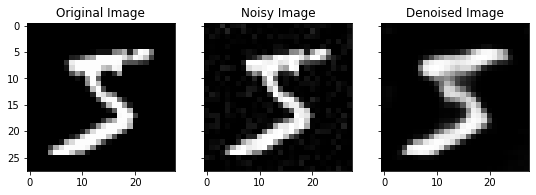

1/1 [==============================] - 0s 15ms/step


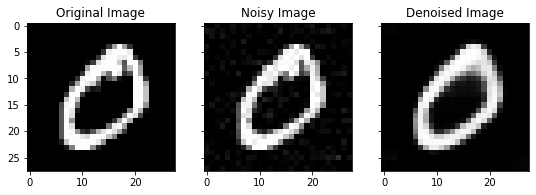

1/1 [==============================] - 0s 17ms/step


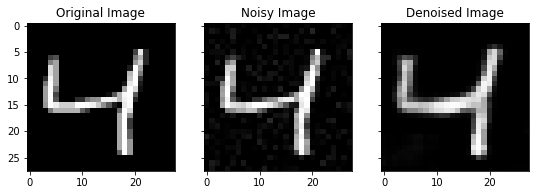

1/1 [==============================] - 0s 16ms/step


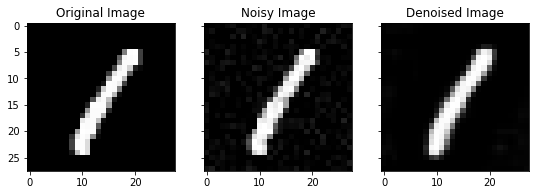

1/1 [==============================] - 0s 17ms/step


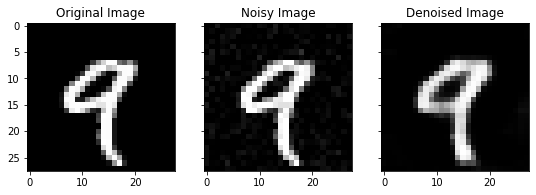

In [14]:
for idx in range(5):
    y = autoencoder.predict(np.expand_dims(x_train_noisy[idx, ...], axis=0))
    
    fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharex='col', sharey='row')
    ax[0].imshow(np.squeeze(x_train[idx, ...]), cmap='gray')
    ax[0].set_title('Original Image')
    ax[1].imshow(np.squeeze(x_train_noisy[idx, ...]), cmap='gray')
    ax[1].set_title('Noisy Image')
    ax[2].imshow(np.squeeze(y), cmap='gray')
    ax[2].set_title('Denoised Image')
    plt.show()

#### Utilización del autoencoder para la extracción de características (características del espacio latente)

In [15]:
# Obtain features from middle layer
autoencoder = load_model(model_name)
encoder = Model(inputs=autoencoder.input, 
                outputs=autoencoder.get_layer('encoder').output)

### Creación de la base de datos 

Creación de la base de datos mediante la extracción de las características del autoencoder para todas las imágenes del conjunto de entrenamiento.

In [16]:
# Extracting features from train data
codes_name = 'learned_codes_mnist.npy'

if not os.path.exists(codes_name):
    learned_codes = encoder.predict(x_train)
    print(learned_codes.shape)
    np.save(codes_name, learned_codes)
else:
    learned_codes = np.load(codes_name)

1875/1875 [==============================] - 3s 2ms/step
(60000, 128)


### Fase de recuperación

Recuperamos las imágenes más parecidas de entre 9 imágenes de prueba.

In [17]:
def euclidean_distance(x ,y):
    return np.sqrt(np.sum(np.square(x - y)))

1/1 [==============================] - 0s 50ms/step


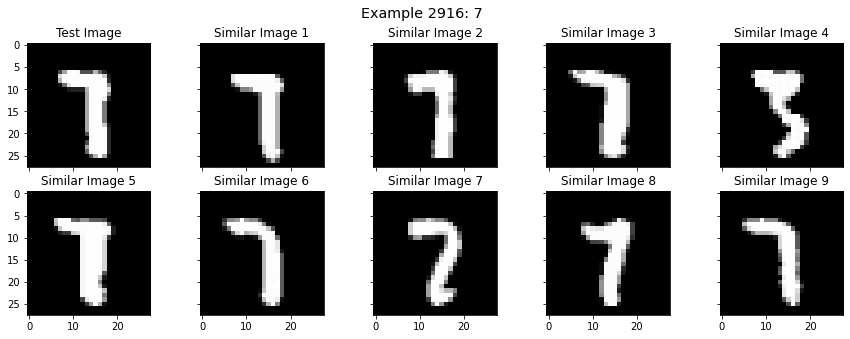

1/1 [==============================] - 0s 25ms/step


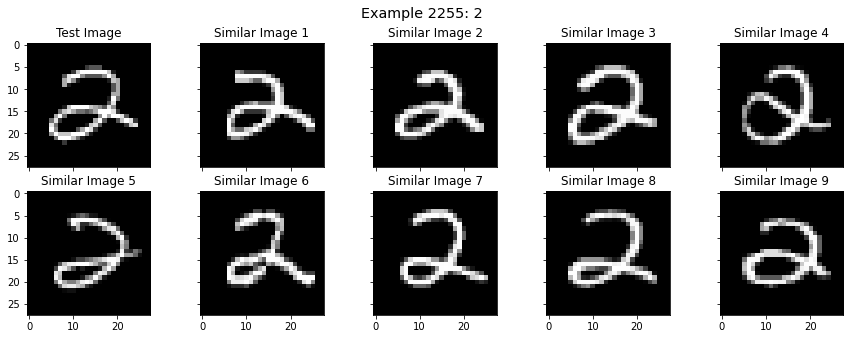

1/1 [==============================] - 0s 18ms/step


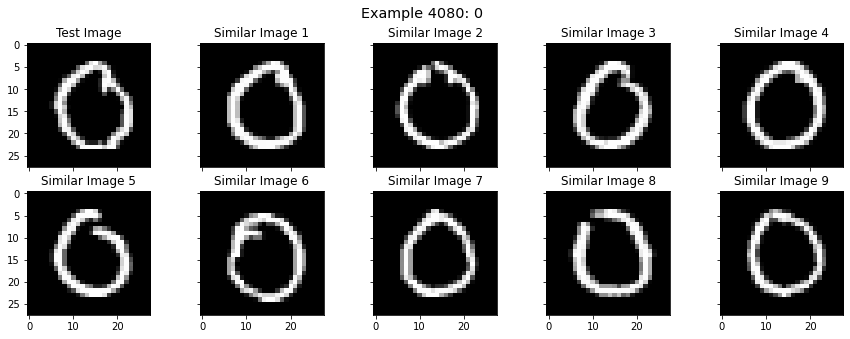

1/1 [==============================] - 0s 17ms/step


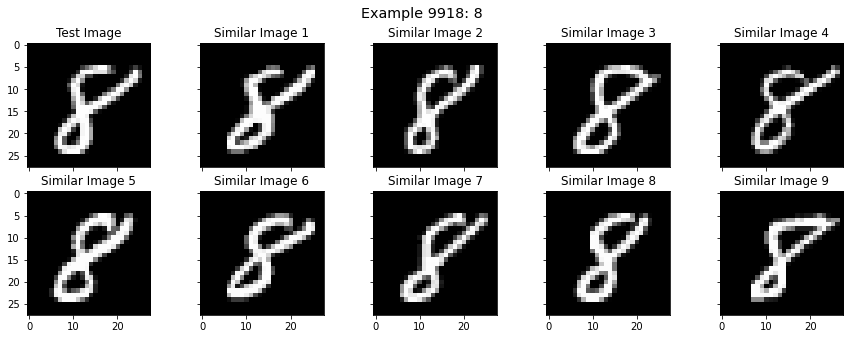

1/1 [==============================] - 0s 15ms/step


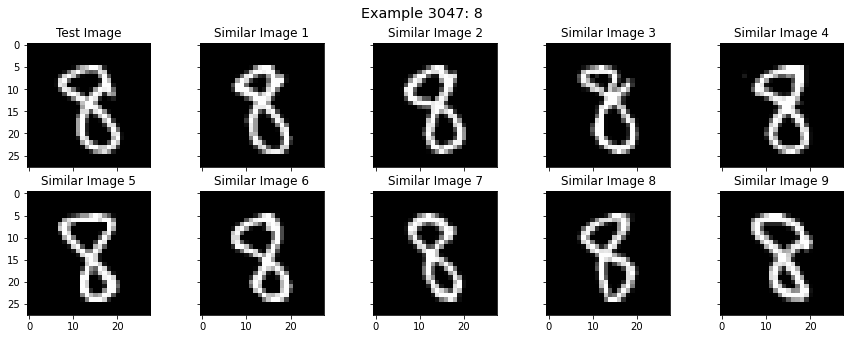

1/1 [==============================] - 0s 16ms/step


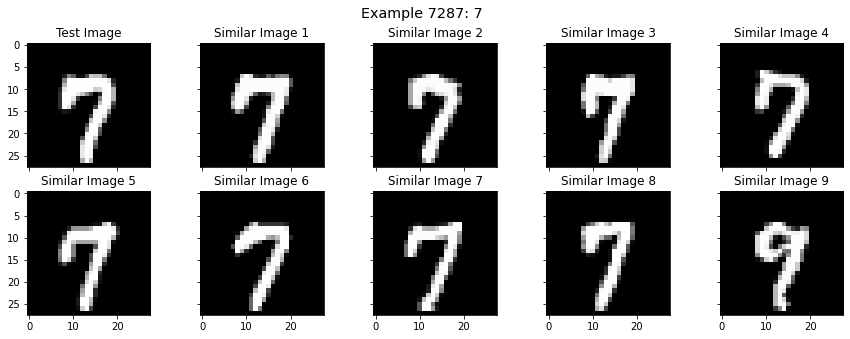

1/1 [==============================] - 0s 14ms/step


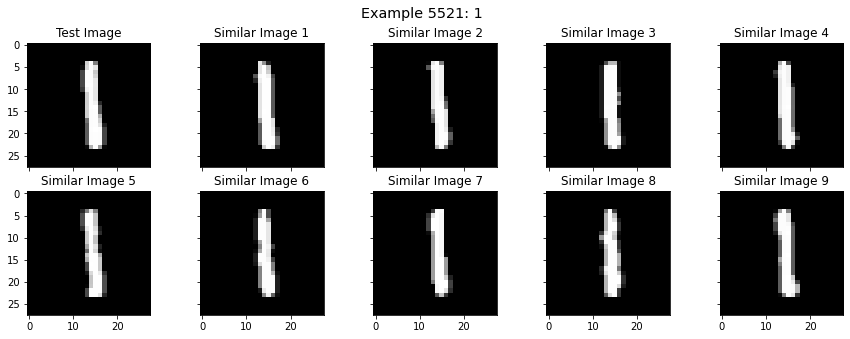

1/1 [==============================] - 0s 15ms/step


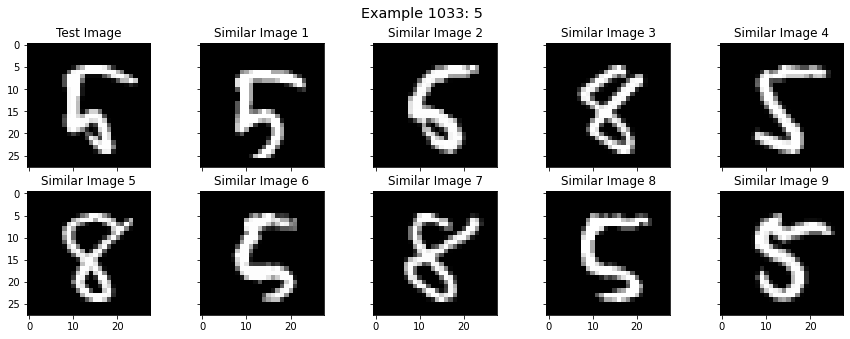

In [18]:
num_retrieve_images = 9
np.random.seed(5)
    
indexes = np.random.randint(0, x_test.shape[0], 8) # Select 8 random images for testing

for idx in indexes:
    # Extract features from test image
    im_test = x_test[idx]
    test_code = encoder.predict(np.expand_dims(im_test, axis=0))
    test_code = np.squeeze(test_code)
    
    # Calculate the distance from
    distances = []
    for code in learned_codes:
        distance = euclidean_distance(code, test_code) # Euclidean norm
        distances.append(distance)
    distances = np.array(distances)
    
    # Ordering the images according to similarity
    sorted_idx = distances.argsort()
    images_idx = sorted_idx[:num_retrieve_images]
    
    
    # Showing the results
    fig, axes = plt.subplots(int((num_retrieve_images + 1)/5 + 0.5), 5,
                           figsize=(15, 5), sharex='col', sharey='row')
    
    fig.suptitle('Example {}: {}'.format(idx + 1, y_test[idx]), fontsize='x-large')
    for ax_idx, ax in enumerate(axes.flat):
        if ax_idx == 0:
            ax.imshow(np.squeeze(im_test), cmap='gray')
            ax.set_title('Test Image')
        else:
            ax.imshow(np.squeeze(x_train[images_idx[ax_idx - 1]]), cmap='gray')
            ax.set_title('Similar Image {}'.format(ax_idx))
            
    plt.show()

    

### Referencias

1. <span id="fn1">Rupapara, Vaibhav, et al. "Auto-Encoders for Content-based Image Retrieval with its Implementation Using Handwritten Dataset." 2020 5th International Conference on Communication and Electronics Systems (ICCES). IEEE, 2020.</span>